In [1]:
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms
from pathlib import Path
from sparse_autoencoder import SparseAutoencoder
import pandas as pd
import numpy as np


def process_image_pipeline(image_path, sae_model_path, output_path):
    """
    Przetwarza obraz przez model CLIP i SAE, a następnie zapisuje wynik.
    :param image_path: Ścieżka do obrazu wejściowego.
    :param sae_model_path: Ścieżka do wytrenowanego modelu SAE.
    :param output_path: Ścieżka do zapisu przetworzonych cech.
    """

    # Wybór urządzenia
    device = "cuda" if torch.cuda.is_available() else ('mps' if torch.backends.mps.is_available() else "cpu")
    print(f"Używane urządzenie: {device}")

    # CLIP
    model, preprocess = clip.load("ViT-L/14", device=device)
    # Załaduj i przetwórz obraz
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    # Przetwarzanie obrazu przez CLIP
    with torch.no_grad():
        image_features = model.encode_image(image)

    # SAE
    def load_sae_model(sae_checkpoint_path):
        state_dict = torch.load(sae_checkpoint_path, map_location=device)
        autoencoder_input_dim = 768  # CLIP ViT-L/14
        expansion_factor = 8
        n_learned_features = int(autoencoder_input_dim * expansion_factor)
        len_hook_points = 1  

        sae = SparseAutoencoder(
            n_input_features=autoencoder_input_dim,
            n_learned_features=n_learned_features,
            n_components=len_hook_points
        ).to(device)

        sae.load_state_dict(state_dict)
        sae.eval()
        return sae  

    # Przepuszczanie CLIP features przez SAE
    @torch.no_grad()
    def get_sae_representation(clip_features, sae_model):
        concepts, _ = sae_model(clip_features)
        return concepts.squeeze()


    sae = load_sae_model(sae_model_path)
    sae_repr = get_sae_representation(image_features, sae)

    # Zapisz wynik
    torch.save(sae_repr.cpu(), output_path)
    print(f"Zapisano: {output_path}")
    return sae_repr.cpu()

In [2]:
from PIL import Image
sae_repr = process_image_pipeline("gee.jpg", "clip_ViT-L_14sparse_autoencoder_final.pt", "dog_sae_concepts.pth")

Używane urządzenie: mps
Zapisano: dog_sae_concepts.pth


In [3]:
sae_repr_np = sae_repr.numpy()
# Sprawdzenie kształtu
print(f"Kształt reprezentacji SAE: {sae_repr_np.shape}")

Kształt reprezentacji SAE: (6144,)


In [4]:
# --- 1. Utworzenie DataFrame z wartościami reprezentacji SAE ---
values = sae_repr.numpy().reshape(-1)  # tablica 1D
concept_strength_df = pd.DataFrame({
    'id': np.arange(len(values)),  # identyfikatory (0, 1, ..., 6143)
    'concept_strength': values
})

# --- 2. Wczytanie nazw konceptów z pliku CSV ---
concept_names_df = pd.read_csv(
    "clip_ViT-L_14concept_names.csv",  # plik CSV z konceptami
    header=None,                       # brak nagłówka w pliku CSV!
    names=['id', 'concept_name']      # nadajemy kolumnom odpowiednie nazwy
)

# --- 3. Połączenie danych według 'id' ---
merged_df = pd.merge(concept_strength_df, concept_names_df, on='id', how='inner')

# --- 4. Sortowanie od najsilniejszego konceptu ---
merged_df_sorted = merged_df.sort_values(by='concept_strength', ascending=False)

# --- 5. Wyświetlenie wyników ---
print(merged_df_sorted.head(10))  # Top 10 konceptów

        id  concept_strength concept_name
111    111          5.086063        birds
1326  1326          3.640913       oregon
3986  3986          3.292149          pic
1019  1019          3.061109     wildlife
4324  4324          2.113908      visitor
184    184          1.671891         audi
5978  5978          1.524759        pixel
316    316          1.508825          dvd
4547  4547          1.465101       ottawa
6111  6111          1.434213     juvenile


In [5]:
from IPython.display import Image, display
def photo_desc(concept_strength_df, concept_name, image):
    
    display(Image(filename=image))
    if concept_name not in concept_strength_df['concept_name'].values:
        print(f"Concept '{concept_name}' not found.")
    else:
        print(f"Strength of '{concept_name}': {concept_strength_df[concept_strength_df['concept_name'] == concept_name]['concept_strength'].values[0]}")
    print(f"Name of the strongest concept: {concept_strength_df['concept_name'].iloc[0]}")
    

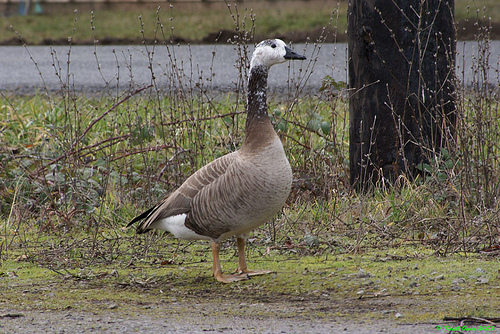

Strength of 'goose': 0.0
Name of the strongest concept: birds


In [6]:
photo_desc(merged_df_sorted, 'goose', "gee.jpg")